In [1]:
# import sys
# !{sys.executable} -m pip install sklearn
# !jupyter nbextension enable --py --sys-prefix widgetsnbextension

# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
from __future__ import print_function, division

import time
import os
import copy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm as tqdm
from skimage import io, transform
from collections import Counter
from sklearn.utils import class_weight

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.autograd import Function

import torchvision
from torchvision import datasets, models, transforms, utils

cudnn.benchmark = True
plt.ion()   # interactive mode

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# path constants
path_to_folder = 'Assignment3_Massaged_Data'
train_images_folder = 'train_set_unsharp'
test_images_folder = 'test_set_luma'
path_to_train_images= path_to_folder + '/' + train_images_folder
path_to_test_images = path_to_folder + '/' + test_images_folder

path_to_train_labels= path_to_folder + '/' + 'train_labels.csv'

In [4]:
image_size = (227, 227)

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.ToTensor()
    ]),
}

In [6]:
class DatasetCustom(Dataset):
    
    def __init__(self, root_dir, csv_path, transform=None):
        self.root = root_dir
        self.dataframe = pd.read_csv(csv_path)
        self.transform = transform
        
    def __len__(self):
        return self.dataframe.shape[0]-1
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        img_name = os.path.join(self.root,
                                self.dataframe.iloc[index, 0])
        
        # Added, since my images are in black and white (luma)
        edgemask = io.imread(img_name)
        image = np.zeros((image_size[0], image_size[1], 3)).astype(np.uint8)
        image[:,:,0] = edgemask
        image[:,:,1] = edgemask
        image[:,:,2] = edgemask
        
        label1 = (self.dataframe.iloc[index, 1])
        label2 = (self.dataframe.iloc[index, 2])
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label1, label2

In [7]:
class TestDatasetCustom(Dataset):
    
    def __init__(self, root_dir, transform=None):
        import glob
        self.root = root_dir
        files = glob.glob(root_dir+'/*.jpg')
        self.files = [root_dir + '/' + str(i) + '.jpg' for i in range(len(files))]
        self.transform = transform
    
    def file_getter(self):
        return self.files
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        
        if torch.is_tensor(index):
            index = index.tolist()
        
        edgemask = io.imread(self.files[index])
        image = np.zeros((image_size[0], image_size[1], 3)).astype(np.uint8)
        image[:,:,0] = edgemask
        image[:,:,1] = edgemask
        image[:,:,2] = edgemask
        
        if self.transform is not None:
            image = self.transform(image)
            
        img_name = self.files[index].split('/')[-1]
        label1 = 3
            
        return img_name, image, label1

In [8]:
train_dataset = DatasetCustom(path_to_train_images, path_to_train_labels, transform=data_transforms['train'])
test_dataset = TestDatasetCustom(path_to_test_images, transform=data_transforms['train'])

In [9]:
batch_size = 32
dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

# Show some training images

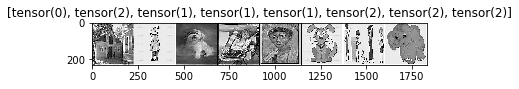

In [10]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
inputs, label1, label2 = next(iter(dataloader))
out = utils.make_grid(inputs[0:8])
imshow(out, title=[x for x in label1[0:8]])


# GPU availability

In [11]:
cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
device

device(type='cuda', index=0)

# Training loop function

In [12]:
# pre-train model
def pre_train_model(model, criterion, optimizer, num_epochs=15):    
    since = time.time()

    best_feature_wts = copy.deepcopy(model.feature_extractor.state_dict())
    best_domain_wts = copy.deepcopy(model.domain_classifier.state_dict())
    best_label_wts = copy.deepcopy(model.label_predictor.state_dict())

    best_label_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.feature_extractor.train()  # Set model to training mode
                model.domain_classifier.train()
                model.label_predictor.train()
            else:
                model.feature_extractor.eval()  # Set model to training mode
                model.domain_classifier.eval()
                model.label_predictor.eval()

            running_label_loss = 0.0
            running_label_corrects = 0

            # Iterate over data.
            for batch_idx, (inputs, _, label2s) in enumerate(tqdm(dataloader)):              
                # batch constants
                inputs = inputs.to(device)
                label2s = label2s.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    # reset gradients
                    model.feature_extractor.zero_grad()
                    model.label_predictor.zero_grad()

                    # get labels
                    feature_vector = model.feature_extractor(inputs).view(inputs.size(0), -1)
                    label_output = model.label_predictor(feature_vector)
                    _, label_preds = torch.max(label_output, 1)              

                    # get loss and optimize if training
                    if phase == 'train':
                        label_loss = criterion.label(label_output, label2s)    
                        label_loss.backward(retain_graph=True)
                        optimizer.label.step()
                        optimizer.feature.step()                    

                # statistics
                running_label_loss += label_loss.item() * inputs.size(0)
                running_label_corrects += torch.sum(label_preds == label2s.data)
                
            epoch_label_loss = running_label_loss / len(dataloader.dataset)
            epoch_label_acc = running_label_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Label_Loss: {epoch_label_loss:.4f} Label_Acc: {epoch_label_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_label_acc > best_label_acc:
                best_label_acc = epoch_label_acc
                best_feature_wts = copy.deepcopy(model.feature_extractor.state_dict())
                best_label_wts = copy.deepcopy(model.label_predictor.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_label_acc:4f}')

    # load best model weights
    model.feature_extractor.load_state_dict(best_feature_wts)
    model.domain_classifier.load_state_dict(best_domain_wts)
    model.label_predictor.load_state_dict(best_label_wts)
    return model

In [25]:
gamma = 10

def train_model(model, criterion, optimizer, num_epochs=25):    
    since = time.time()

    best_feature_wts = copy.deepcopy(model.feature_extractor.state_dict())
    best_domain_wts = copy.deepcopy(model.domain_classifier.state_dict())
    best_label_wts = copy.deepcopy(model.label_predictor.state_dict())

    best_label_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.feature_extractor.train()  # Set model to training mode
                model.domain_classifier.train()
                model.label_predictor.train()
            else:
                model.feature_extractor.eval()  # Set model to training mode
                model.domain_classifier.eval()
                model.label_predictor.eval()

            # epoch constants
            start_steps = epoch * len(dataloader.dataset)
            total_steps = num_epochs * len(dataloader.dataset)
            running_feature_loss = 0.0
            running_domain_loss = 0.0
            running_label_loss = 0.0
            running_domain_corrects = 0
            running_label_corrects = 0

            # Iterate over data.
            for batch_idx, ((source_inputs, source_label1s, source_label2s), (_, target_inputs, target_label1s)) in enumerate(zip(tqdm(dataloader), tqdm(test_dataloader))):
                # batch constants
                all_inputs = torch.cat([source_inputs, target_inputs], 0)
                all_label1s = torch.cat([source_label1s, target_label1s], 0)

                source_inputs = source_inputs.to(device)
                source_label1s = source_label1s.to(device)
                source_label2s = source_label2s.to(device)
                all_inputs = all_inputs.to(device)
                all_label1s = all_label1s.to(device)

                # setup hyperparameters
                p = float(batch_idx + start_steps) / total_steps
                lambd = round(2. / (1. + np.exp(-gamma * p)) - 1, 3)
                lr = 0.1 / (1. + 10 * p)**0.75
                
                # update lambda and learning rate
                model.domain_classifier.set_lambda(lambd)
                optimizer.feature.lr = lr
                optimizer.domain.lr = lr
                optimizer.label.lr = lr

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    # 1) train feature_extractor and label_predictor
                    
                    # reset gradients
                    model.feature_extractor.zero_grad()
                    model.label_predictor.zero_grad()

                    # get labels
                    # feature_vector = model.feature_extractor(src_inputs)
                    feature_vector = model.feature_extractor(source_inputs)
                    label_output = model.label_predictor(feature_vector)
                    _, label_preds = torch.max(label_output, 1)

                    # label2s[label2s == -1] = label_preds[label2s == -1]

                    # get loss and optimize if training
                    if phase == 'train':
                        # label_loss = criterion.label(label_output, src_label2s)    
                        label_loss = criterion.label(label_output, source_label2s)    
                        label_loss.backward(retain_graph=True)
                        optimizer.label.step()
                        optimizer.feature.step()
                    

                    # 2) train feature_extractor and domain_classifier
                    
                    # reset gradients
                    model.feature_extractor.zero_grad()
                    model.domain_classifier.zero_grad()
                    model.domain_classifier.set_lambda(lambd)

                    # get domains
                    feature_vector = model.feature_extractor(all_inputs)
                    domain_output = model.domain_classifier(feature_vector)
                    _, domain_preds = torch.max(domain_output, 1)

                    # get loss and optimize if training
                    if phase == 'train':
                        domain_loss = criterion.domain(domain_output, all_label1s)    
                        domain_loss.backward(retain_graph=True)
                        optimizer.domain.step()
                        optimizer.feature.step()

                # statistics
                # running_feature_loss += loss.item() * inputs.size(0)
                running_domain_loss += domain_loss.item() * all_inputs.size(0)
                running_label_loss += label_loss.item() * source_inputs.size(0)

                running_domain_corrects += torch.sum(domain_preds == all_label1s.data)
                running_label_corrects += torch.sum(label_preds == source_label2s.data)
                

            # epoch_feature_loss = running_feature_loss / len(dataloader.dataset)
            epoch_domain_loss = running_domain_loss / len(dataloader.dataset)
            epoch_label_loss = running_label_loss / len(dataloader.dataset)
            epoch_domain_acc = running_domain_corrects.double() / len(dataloader.dataset)
            epoch_label_acc = running_label_corrects.double() / len(dataloader.dataset)

            # print(f'{phase} Feature_Loss: {epoch_feature_loss:.4f}')
            print(f'{phase} Domain_Loss: {epoch_domain_loss:.4f} Domain_Acc: {epoch_domain_acc:.4f}')
            print(f'{phase} Label_Loss: {epoch_label_loss:.4f} Label_Acc: {epoch_label_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_label_acc > best_label_acc:
                best_label_acc = epoch_label_acc
                best_feature_wts = copy.deepcopy(model.feature_extractor.state_dict())
                best_domain_wts = copy.deepcopy(model.domain_classifier.state_dict())
                best_label_wts = copy.deepcopy(model.label_predictor.state_dict())


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_label_acc:4f}')

    # load best model weights
    model.feature_extractor.load_state_dict(best_feature_wts)
    model.domain_classifier.load_state_dict(best_domain_wts)
    model.label_predictor.load_state_dict(best_label_wts)
    return model

# Model selection

In [14]:
# define custom modules and layers, because loss.backwards doesn't seem to work when I use nn.Sequential

# custom layer to reverse gradient
class GradientReverse(torch.autograd.Function):
    scale = 1.0
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return GradientReverse.scale * grad_output.neg()
    
def grad_reverse(x, scale=1.0):
    scale = torch.tensor(1.0, requires_grad=False)
    GradientReverse.scale = scale
    return GradientReverse.apply(x)

# need to make a custom domain classifier class, because the lambda and learning rate are changing
class DomainClassifier(nn.Module):
    def __init__(self, num_ftrs):
        super(DomainClassifier, self).__init__()
        # self.fc1 = nn.Linear(num_ftrs, 100) 
        # self.fc2 = nn.Linear(100, 3)
        # self.drop = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(num_ftrs, 4)

    def set_lambda(self, lambd):
        self.lambd = lambd
        
    def forward(self, x):
        x = grad_reverse(x, self.lambd)
        # x = F.leaky_relu(self.drop(self.fc1(x)))
        # x = F.leaky_relu(self.fc1(x))
        # x = self.fc2(x)
        x = self.fc1(x)
        return F.softmax(x, dim=1)

class LabelPredictor(nn.Module):
    def __init__(self, num_ftrs):
        super(LabelPredictor, self).__init__()
        # self.fc1 = nn.Linear(num_ftrs, 100)
        # self.fc2 = nn.Linear(100, 100)
        # self.fc3 = nn.Linear(100, 7)
        # self.drop = nn.Dropout2d(0.2)
        self.fc1 = nn.Linear(num_ftrs, 7)
        
    def forward(self, x):
        # x = F.relu(self.fc1(x))
        # x = self.fc3(x)
        x = self.fc1(x)
        return F.softmax(x, dim=1)

class DANN_Model:
    feature_extractor: object
    domain_classifier: object
    label_predictor: object

In [15]:
# set up Feature Extractor CNN
feature_extractor = models.resnet18(pretrained=True)
num_ftrs = feature_extractor.fc.in_features
feature_extractor.fc = nn.Identity()

domain_classifier  = DomainClassifier(num_ftrs)
label_predictor = LabelPredictor(num_ftrs)

model_ft = DANN_Model()
model_ft.feature_extractor = feature_extractor
model_ft.domain_classifier = domain_classifier
model_ft.label_predictor = label_predictor

# Loss function

In [16]:
domain_train = dataloader.dataset.dataframe['label1']
domain_all = pd.concat([domain_train, pd.Series([3]).repeat(len(domain_train.index))], ignore_index=True)
domain_class_weight = class_weight.compute_class_weight(class_weight='balanced', classes=list(range(4)), y=domain_all)
domain_class_weight=torch.tensor(domain_class_weight, dtype=torch.float).to(device)

label_all = dataloader.dataset.dataframe['label2']
label_class_weight = class_weight.compute_class_weight(class_weight='balanced', classes=list(range(7)), y=label_all)
label_class_weight=torch.tensor(label_class_weight, dtype=torch.float).to(device)

print(domain_class_weight)
print(label_class_weight)

tensor([1.8150, 1.4800, 1.2931, 0.5000], device='cuda:0')
tensor([1.0652, 1.7149, 1.0035, 0.9049, 1.1961, 0.9475, 0.6734],
       device='cuda:0')


In [17]:
class DANN_Criterion:
    domain: object
    label: object

criterion = DANN_Criterion()
criterion.domain = nn.CrossEntropyLoss(weight=domain_class_weight)
criterion.label = nn.CrossEntropyLoss(weight=label_class_weight)

# Optimizer and Scheduler

In [18]:
lr = 0.01
momentum = 0.9

class DANN_Optimizer:
    feature: object
    domain: object
    label: object

# Observe that all parameters are being optimized
optimizer_ft = DANN_Optimizer()
optimizer_ft.feature = optim.SGD(model_ft.feature_extractor.parameters(), lr=lr, momentum=momentum)
optimizer_ft.domain = optim.SGD(model_ft.domain_classifier.parameters(), lr=lr, momentum=momentum)
optimizer_ft.label = optim.SGD(model_ft.label_predictor.parameters(), lr=lr, momentum=momentum)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Training

In [19]:
# put to device
model_ft.feature_extractor = model_ft.feature_extractor.to(device)
model_ft.domain_classifier = model_ft.domain_classifier.to(device)
model_ft.label_predictor = model_ft.label_predictor.to(device)

model_ft = pre_train_model(model_ft, criterion, optimizer_ft, num_epochs=3)

  0%|          | 0/190 [00:00<?, ?it/s]


Epoch 0/2
----------


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  1%|          | 1/190 [00:00<00:22,  8.47it/s]

train Label_Loss: 1.4648 Label_Acc: 0.7235


  1%|          | 1/190 [00:00<00:35,  5.31it/s]

val Label_Loss: 1.4371 Label_Acc: 0.9098

Epoch 1/2
----------


  0%|          | 0/190 [00:00<?, ?it/s]

train Label_Loss: 1.2594 Label_Acc: 0.9129


  0%|          | 0/190 [00:00<?, ?it/s]

val Label_Loss: 1.1831 Label_Acc: 0.9513

Epoch 2/2
----------


  1%|          | 2/190 [00:00<00:17, 10.45it/s]

train Label_Loss: 1.2193 Label_Acc: 0.9513


100%|██████████| 190/190 [00:18<00:00, 10.06it/s]

val Label_Loss: 1.2240 Label_Acc: 0.9502
Training complete in 2m 48s
Best val Acc: 0.951328


In [26]:
# put to device
model_ft.feature_extractor = model_ft.feature_extractor.to(device)
model_ft.domain_classifier = model_ft.domain_classifier.to(device)
model_ft.label_predictor = model_ft.label_predictor.to(device)

model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=5)


Epoch 0/4
----------


train Domain_Loss: 1.4578 Domain_Acc: 0.3377
train Label_Loss: 1.1727 Label_Acc: 0.9947


val Domain_Loss: 1.2823 Domain_Acc: 0.3377
val Label_Loss: 1.2144 Label_Acc: 0.9977

Epoch 1/4
----------


train Domain_Loss: 1.4578 Domain_Acc: 0.3377
train Label_Loss: 1.1723 Label_Acc: 0.9947


val Domain_Loss: 1.4953 Domain_Acc: 0.3377
val Label_Loss: 1.1692 Label_Acc: 0.9980

Epoch 2/4
----------


train Domain_Loss: 1.4580 Domain_Acc: 0.3377
train Label_Loss: 1.1708 Label_Acc: 0.9954


val Domain_Loss: 1.3404 Domain_Acc: 0.3377
val Label_Loss: 1.1689 Label_Acc: 0.9980

Epoch 3/4
----------


train Domain_Loss: 1.4577 Domain_Acc: 0.3377
train Label_Loss: 1.1689 Label_Acc: 0.9977


val Domain_Loss: 1.4027 Domain_Acc: 0.3377
val Label_Loss: 1.1655 Label_Acc: 0.9982

Epoch 4/4
----------


train Domain_Loss: 1.4578 Domain_Acc: 0.3377
train Label_Loss: 1.1690 Label_Acc: 0.9974


val Domain_Loss: 1.2690 Domain_Acc: 0.3377
val Label_Loss: 1.1690 Label_Acc: 0.9984
Training complete in 7m 44s
Best val Acc: 0.998350


# Test data loader

In [27]:
test_dataloader = DataLoader(test_dataset, batch_size=1,
                        shuffle=False, num_workers=0)

# Saving the result

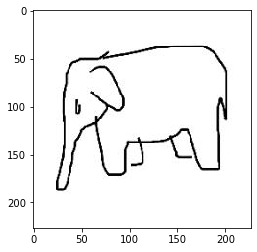

tensor([[0.0019, 0.0017, 0.0028, 0.0531, 0.8205, 0.1113, 0.0086]])


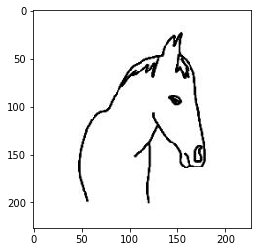

tensor([[2.7656e-04, 9.4843e-05, 2.9626e-04, 1.6745e-04, 9.9904e-01, 2.1135e-05,
         1.0126e-04]])


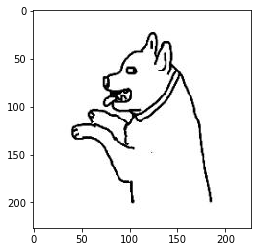

tensor([[8.7955e-06, 9.3791e-06, 3.9835e-06, 9.9992e-01, 1.4849e-05, 3.3312e-08,
         4.3018e-05]])


In [28]:
total = 0
empty_dictionary = {'id': np.zeros((len(test_dataloader))), 'label': np.zeros((len(test_dataloader)))}
predicted_df = pd.DataFrame(data=empty_dictionary)
predicted_df['id'] = predicted_df['id'].apply(str)
predicted_df['label'] = predicted_df['label'].astype(int)
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    feature_extractor = model_ft.feature_extractor.cpu()
    domain_classifier = model_ft.domain_classifier.cpu()
    label_predictor = model_ft.label_predictor.cpu()
    for index, values in enumerate(tqdm(test_dataloader)):
        # calculate outputs by running images through the network
        image = values
        image_name = image[0]
        image_file = image[1]
        image_file = image_file.cpu().float()

        feature_vector = feature_extractor(image_file).view(1, -1)
        output = label_predictor(feature_vector)
        
        _, predicted = torch.max(output.data, 1)
        
        if index==1 or index==10 or index==20:
            out = torchvision.utils.make_grid(image_file)
            imshow(out)
            print(output)
        
        predicted_df.at[index,'id'] = image_name[0].replace('jpg', 'png')
        predicted_df.at[index,'label'] = str(predicted.numpy()[0])
        

In [29]:
predicted_df.to_csv('rochi_15-04-2022_9.csv', index = False)